<div class="alert alert-block alert-success" style="font-size:25px">
🦴 1. Imports, constants, dependencies 🦴
</div>

In [1]:
try:
    import pylibjpeg
    print('import pylibjpeg success')
except:
    # The following *.whl files were collected from these pip packages:
    #!pip install -U "python-gdcm" pydicom pylibjpeg    # Required for JPEG decompression. See: https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/341412
    #!pip install -U torchvision                        # For EfficientNetV2

    # Offline dependencies:
    !mkdir -p /root/.cache/torch/hub/checkpoints/
    !cp ../input/rsna-2022-whl/efficientnet_v2_s-dd5fe13b.pth  /root/.cache/torch/hub/checkpoints/
    !pip install /kaggle/input/rsna-2022-whl/{pydicom-2.3.0-py3-none-any.whl,pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}
    !pip install /kaggle/input/rsna-2022-whl/{torch-1.12.1-cp37-cp37m-manylinux1_x86_64.whl,torchvision-0.13.1-cp37-cp37m-manylinux1_x86_64.whl}

import pylibjpeg success


In [4]:
import gc
import glob
import os
import re

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom as dicom
import torch
import torchvision as tv
from sklearn.model_selection import GroupKFold
from torch.cuda.amp import GradScaler, autocast
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm.notebook import tqdm

import wandb

plt.rcParams['figure.figsize'] = (20, 5)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 1000)

# Effnet
WEIGHTS = tv.models.efficientnet.EfficientNet_V2_M_Weights.DEFAULT
print(WEIGHTS.transforms())
RSNA_2022_PATH = '../input/rsna-2022-cervical-spine-fracture-detection'
TRAIN_IMAGES_PATH = f'{RSNA_2022_PATH}/train_images'
TEST_IMAGES_PATH = f'{RSNA_2022_PATH}/test_images'
EFFNET_MAX_TRAIN_BATCHES = 4000
EFFNET_MAX_EVAL_BATCHES = 200
ONE_CYCLE_MAX_LR = 0.0001
ONE_CYCLE_PCT_START = 0.3
SAVE_CHECKPOINT_EVERY_STEP = 1000
EFFNET_CHECKPOINTS_PATH = '../input/rsna-2022-base-effnetv2'
FRAC_LOSS_WEIGHT = 2.
N_FOLDS = 5
METADATA_PATH = '../input/vertebrae-detection-checkpoints'

PREDICT_MAX_BATCHES = 1e9

# Common
try:
    from kaggle_secrets import UserSecretsClient
    IS_KAGGLE = True
except:
    IS_KAGGLE = False

os.environ["WANDB_MODE"] = "online"
if os.environ["WANDB_MODE"] == "online":
    if IS_KAGGLE:
        os.environ['WANDB_API_KEY'] = '67c99389e1ae37b747c40634c51802a4bf019d49'

if not IS_KAGGLE:
    print('Running locally')
    # RSNA_2022_PATH = f'/root/autodl-tmp/RSNA_data'
    RSNA_2022_PATH = f'/mnt/e/Code/Kaggle/RSNA_data'
    TRAIN_IMAGES_PATH = f'{RSNA_2022_PATH}/train_images'
    TEST_IMAGES_PATH = f'{RSNA_2022_PATH}/test_images'
    METADATA_PATH = f'{RSNA_2022_PATH}/Metadata'
    EFFNET_CHECKPOINTS_PATH = f'{RSNA_2022_PATH}/effnetv2'
    os.environ['WANDB_API_KEY'] = '67c99389e1ae37b747c40634c51802a4bf019d49'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cuda':
    BATCH_SIZE = 32
else:
    BATCH_SIZE = 2


ImageClassification(
    crop_size=[480]
    resize_size=[480]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
Running locally


<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 2. Loading train/eval/test dataframes 🦴
</div>

### Train data

1. Loading data from competition dataset folder `../input/rsna-2022-cervical-spine-fracture-detection/train.csv`
2. Joining data with slice information from metadata dataset `../input/rsna-2022-spine-fracture-detection-metadata/meta_train_with_vertebrae.csv`
3. Adding `Splits` column to facilitate train/eval splits.

In [5]:
df_train = pd.read_csv(f'{RSNA_2022_PATH}/train.csv')
print(len(df_train))
df_train = df_train.drop(df_train[df_train['StudyInstanceUID'] == '1.2.826.0.1.3680043.20574'].index)
df_train = df_train.drop(df_train[df_train['StudyInstanceUID'] == '1.2.826.0.1.3680043.20756'].index)
df_train = df_train.drop(df_train[df_train['StudyInstanceUID'] == '1.2.826.0.1.3680043.29952'].index)
df_train = df_train.drop(df_train[df_train['StudyInstanceUID'] == '1.2.826.0.1.3680043.8362'].index)
print(len(df_train))
df_train.sample(2)

2019
2015


,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
202,1.2.826.0.1.3680043.1573,1,1,0,0,0,1,1,1
160,1.2.826.0.1.3680043.31352,1,0,0,0,0,1,1,1


In [6]:
# rsna-2022-spine-fracture-detection-metadata contains inference of C1-C7 vertebrae for all training sample (95% accuracy)
df_train_slices = pd.read_csv(f'{METADATA_PATH}/train_segmented.csv')
c1c7 = [f'C{i}' for i in range(1, 8)]
df_train_slices[c1c7] = (df_train_slices[c1c7] > 0.5).astype(int)
print(df_train_slices.sample(5)[['StudyInstanceUID', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].to_markdown())

|        | StudyInstanceUID          |   C1 |   C2 |   C3 |   C4 |   C5 |   C6 |   C7 |
|-------:|:--------------------------|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
| 307260 | 1.2.826.0.1.3680043.22757 |    0 |    0 |    0 |    1 |    1 |    0 |    0 |
| 221508 | 1.2.826.0.1.3680043.19397 |    0 |    0 |    0 |    0 |    0 |    0 |    0 |
| 499067 | 1.2.826.0.1.3680043.30713 |    0 |    0 |    1 |    1 |    0 |    0 |    0 |
|  55344 | 1.2.826.0.1.3680043.12639 |    0 |    0 |    0 |    0 |    0 |    0 |    0 |
| 579879 | 1.2.826.0.1.3680043.4517  |    0 |    0 |    0 |    0 |    1 |    1 |    0 |


In [7]:
df_train = df_train_slices.set_index('StudyInstanceUID').join(df_train.set_index('StudyInstanceUID'),
                                                              rsuffix='_fracture').reset_index().copy()
df_train = df_train.query('StudyInstanceUID != "1.2.826.0.1.3680043.20574"').reset_index(drop=True)
df_train.sample(2)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7,patient_overall,C1_fracture,C2_fracture,C3_fracture,C4_fracture,C5_fracture,C6_fracture,C7_fracture
77156,1.2.826.0.1.3680043.13479,56,512,512,1.0,-126.207000,-83.551030,-457.5,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
513490,1.2.826.0.1.3680043.31328,215,512,512,0.6,-83.291992,-293.791992,-375.5,0,0,1,1,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
split = GroupKFold(N_FOLDS)
for k, (_, test_idx) in enumerate(split.split(df_train, groups=df_train.StudyInstanceUID)):
    df_train.loc[test_idx, 'split'] = k
df_train.sample(2)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7,patient_overall,C1_fracture,C2_fracture,C3_fracture,C4_fracture,C5_fracture,C6_fracture,C7_fracture,split
314998,1.2.826.0.1.3680043.2297,580,512,512,0.625,-90.000000,-56.877000,-94.836,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0
11746,1.2.826.0.1.3680043.10673,152,512,512,1.000,-75.869141,-223.369141,-687.900,0,0,0,0,0,0,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0


### Test data

1. Loading data from competition dataset folder `../input/rsna-2022-cervical-spine-fracture-detection/test.csv`
2. Joining data with slice information collected from test image folders `../input/rsna-2022-cervical-spine-fracture-detection/test_images/*/*`

In [9]:
df_test = pd.read_csv(f'{RSNA_2022_PATH}/test.csv')

if df_test.iloc[0].row_id == '1.2.826.0.1.3680043.10197_C1':
    # test_images and test.csv are inconsistent in the dev dataset, fixing labels for the dev run.
    df_test = pd.DataFrame({
        "row_id": ['1.2.826.0.1.3680043.22327_C1', '1.2.826.0.1.3680043.25399_C1', '1.2.826.0.1.3680043.5876_C1'],
        "StudyInstanceUID": ['1.2.826.0.1.3680043.22327', '1.2.826.0.1.3680043.25399', '1.2.826.0.1.3680043.5876'],
        "prediction_type": ["C1", "C1", "patient_overall"]}
    )

df_test

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.22327_C1,1.2.826.0.1.3680043.22327,C1
1,1.2.826.0.1.3680043.25399_C1,1.2.826.0.1.3680043.25399,C1
2,1.2.826.0.1.3680043.5876_C1,1.2.826.0.1.3680043.5876,patient_overall


In [10]:
test_slices = glob.glob(f'{TEST_IMAGES_PATH}/*/*')
print(test_slices[0])
print(f'{TEST_IMAGES_PATH}/(.*)/(.*).dcm')
test_slices = [re.findall(f'{TEST_IMAGES_PATH}/(.*)/(.*).dcm', s)[0] for s in test_slices]
print(test_slices[0])
df_test_slices = pd.DataFrame(data=test_slices, columns=['StudyInstanceUID', 'Slice'])
df_test_slices.sample(2)

/mnt/e/Code/Kaggle/RSNA_data/test_images/1.2.826.0.1.3680043.22327/1.dcm
/mnt/e/Code/Kaggle/RSNA_data/test_images/(.*)/(.*).dcm
('1.2.826.0.1.3680043.22327', '1')


,StudyInstanceUID,Slice
479,1.2.826.0.1.3680043.25399,249
294,1.2.826.0.1.3680043.22327,82


In [11]:
df_test = df_test.set_index('StudyInstanceUID').join(df_test_slices.set_index('StudyInstanceUID')).reset_index()
df_test.sample(2)

,StudyInstanceUID,row_id,prediction_type,Slice
218,1.2.826.0.1.3680043.22327,1.2.826.0.1.3680043.22327_C1,C1,296
819,1.2.826.0.1.3680043.25399,1.2.826.0.1.3680043.25399_C1,C1,62


<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 3. Dataset class 🦴
</div>

`EffnetDataSet` class returns images of individual slices. It uses a dataframe parameter `df` as a source of slices metadata to locate and load images from `path` folder. It accepts transforms parameter which we set to `WEIGHTS.transforms()`. This is a set of transforms used to pre-train the model on ImageNet dataset.

Text(0.5, 1.0, 'jpeg')

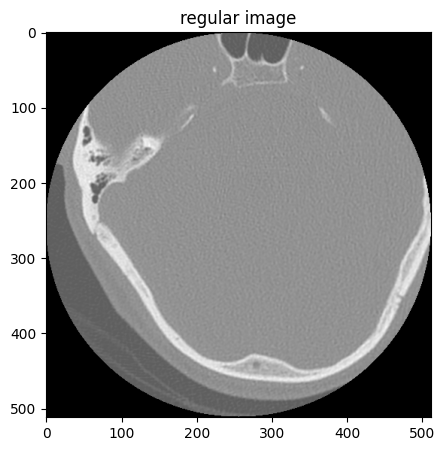

Error in callback <function flush_figures at 0x7f647a8b6c10> (for post_execute):


KeyboardInterrupt: 

In [12]:
def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img


im, meta = load_dicom(
    f'{TRAIN_IMAGES_PATH}/1.2.826.0.1.3680043.10001/1.dcm')
plt.figure()
plt.imshow(im)
plt.title('regular image')

im, meta = load_dicom(
    f'{TRAIN_IMAGES_PATH}/1.2.826.0.1.3680043.10001/1.dcm')
plt.figure()
plt.imshow(im)
plt.title('jpeg')

In [ ]:
class EffnetDataSet(torch.utils.data.Dataset):
    def __init__(self, df, path, transforms=None):
        super().__init__()
        self.df = df
        self.path = path
        self.transforms = transforms

    def __getitem__(self, i):
        path = os.path.join(self.path, self.df.iloc[i].StudyInstanceUID, f'{self.df.iloc[i].Slice}.dcm')

        try:
            img = load_dicom(path)[0]
            # Pytorch uses (batch, channel, height, width) order. Converting (height, width, channel) -> (channel, height, width)
            img = np.transpose(img, (2, 0, 1))
            if self.transforms is not None:
                img = self.transforms(torch.as_tensor(img))
        except Exception as ex:
            print(ex)
            return None

        if 'C1_fracture' in self.df:
            frac_targets = torch.as_tensor(self.df.iloc[i][['C1_fracture', 'C2_fracture', 'C3_fracture', 'C4_fracture',
                                                            'C5_fracture', 'C6_fracture', 'C7_fracture']].astype(
                'float32').values)
            vert_targets = torch.as_tensor(
                self.df.iloc[i][['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].astype('float32').values)
            frac_targets = frac_targets * vert_targets  # we only enable targets that are visible on the current slice
            return img, frac_targets, vert_targets
        return img

    def __len__(self):
        return len(self.df)


In [ ]:
ds_train = EffnetDataSet(df_train, TRAIN_IMAGES_PATH, WEIGHTS.transforms())
X, y_frac, y_vert = ds_train[42]
print(X.shape, y_frac.shape, y_vert.shape)

In [ ]:
def plot_sample_patient(df, ds):
    patient = np.random.choice(df.query('patient_overall > 0').StudyInstanceUID)
    df = df.query('StudyInstanceUID == @patient')
    display(df)

    frac = np.stack([ds[i][1] for i in df.index])
    vert = np.stack([ds[i][2] for i in df.index])
    ax = plt.subplot(1, 2, 1)
    ax.plot(frac)
    ax.set_title(f'Vertebrae with fractures by slice (masked by visible vertebrae). uid:{patient}')
    ax = plt.subplot(1, 2, 2)
    ax.set_title(f'Visible vertebrae by slice. uid:{patient}')
    ax.plot(vert)

# plot_sample_patient(df_train, ds_train)

In [ ]:
# Only X values returned by the test dataset
ds_test = EffnetDataSet(df_test, TEST_IMAGES_PATH, WEIGHTS.transforms())
X = ds_test[42]
X.shape

<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 4. Model 🦴
</div>


In Pytorch we use create_feature_extractor to access feature layers of pre-existing models. Final flat layer of `efficientnet_v2_s` model is called `flatten`. We'll build our classification layer on top of it. 

In [ ]:
from tensorboardX import SummaryWriter
from torch.autograd import Variable

writer = SummaryWriter(log_dir='./log', comment='effnet')


In [ ]:
class EffnetModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        effnet = tv.models.efficientnet_v2_m(weights=WEIGHTS)
        self.model = create_feature_extractor(effnet, ['flatten'])
        with writer:
            writer.add_graph(effnet, (Variable(torch.rand(32, 3, 384, 384)),))

        self.nn_fracture = torch.nn.Sequential(
            torch.nn.Linear(1280, 7),
        )
        self.nn_vertebrae = torch.nn.Sequential(
            torch.nn.Linear(1280, 7),
        )

    def forward(self, x):
        # returns logits
        x = self.model(x)['flatten']
        return self.nn_fracture(x), self.nn_vertebrae(x)

    def predict(self, x):
        frac, vert = self.forward(x)
        return torch.sigmoid(frac), torch.sigmoid(vert)

model = EffnetModel()
with writer:
    writer.add_graph(model, (Variable(torch.rand(1, 3, 384, 384)),))
# model.predict(torch.randn(1, 3, 512, 512))
del model

<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 5.1 Train: loss function 🦴
</div>

We use weighted loss here. See definition here: https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/340392
Weighted loss helps us to optimize the same target that is used in the final scoring.

Auxiliary vertebrae detection loss is added in the training/evaluation loop to improve model's performance.

In [ ]:
def weighted_loss(y_pred_logit, y, reduction='mean', verbose=False):
    """
    Weighted loss
    We reuse torch.nn.functional.binary_cross_entropy_with_logits here. pos_weight and weights combined give us necessary coefficients described in https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/340392

    See also this explanation: https://www.kaggle.com/code/samuelcortinhas/rsna-fracture-detection-in-depth-eda/notebook
    """

    neg_weights = (torch.tensor([7., 1, 1, 1, 1, 1, 1, 1]) if y_pred_logit.shape[-1] == 8 else torch.ones(y_pred_logit.shape[-1])).to(DEVICE)
    pos_weights = (torch.tensor([14., 2, 2, 2, 2, 2, 2, 2]) if y_pred_logit.shape[-1] == 8 else torch.ones(y_pred_logit.shape[-1]) * 2.).to(DEVICE)

    loss = torch.nn.functional.binary_cross_entropy_with_logits(
        y_pred_logit,
        y,
        reduction='none',
    )

    if verbose:
        print('loss', loss)

    pos_weights = y * pos_weights.unsqueeze(0)
    neg_weights = (1 - y) * neg_weights.unsqueeze(0)
    all_weights = pos_weights + neg_weights

    if verbose:
        print('all weights', all_weights)

    loss *= all_weights
    if verbose:
        print('weighted loss', loss)

    norm = torch.sum(all_weights, dim=1).unsqueeze(1)
    if verbose:
        print('normalization factors', norm)

    loss /= norm
    if verbose:
        print('normalized loss', loss)

    loss = torch.sum(loss, dim=1)
    if verbose:
        print('summed up over patient_overall-C1-C7 loss', loss)

    if reduction == 'mean':
        return torch.mean(loss)
    return loss

In [ ]:
# Quick test of  patient_overall + C1-C7 loss
# weighted_loss(
#     torch.logit(torch.tensor([
#         [0.1, 0.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
#         [0.1, 0.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
#     ])).to(DEVICE),
#     torch.tensor([
#         [1., 1., 0., 0., 0., 0., 0., 0.],
#         [0., 0, 0., 0., 0., 0., 0., 0.]
#     ]).to(DEVICE),
#     reduction=None,
#     verbose=True
# )

In [ ]:
# Quick test of C1-C7 loss
weighted_loss(
    torch.logit(torch.tensor([
        [0.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
    ])).to(DEVICE),
    torch.tensor([
        [1., 0., 0., 0., 0., 0., 0.],
        [0, 0., 0., 0., 0., 0., 0.]
    ]).to(DEVICE),
    reduction=None,
    verbose=True
)

<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 5.2 Train: training/evaluation loop 🦴
</div>

In [ ]:
def filter_nones(b):
    return torch.utils.data.default_collate([v for v in b if v is not None])

In [ ]:
def save_model(name, model):
    torch.save(model.state_dict(), f'{name}.tph')

In [ ]:
def load_model(model, name, path='.'):
    data = torch.load(os.path.join(path, f'{name}.tph'), map_location=DEVICE)
    model.load_state_dict(data)
    return model


# quick test
# model = torch.nn.Linear(2, 1)
# save_model('testmodel', model)

# model1 = load_model(torch.nn.Linear(2, 1), 'testmodel')
# assert torch.all(
#     next(iter(model1.parameters())) == next(iter(model.parameters()))
# ).item(), "Loading/saving is inconsistent!"

In [ ]:
def evaluate_effnet(model: EffnetModel, ds, max_batches=PREDICT_MAX_BATCHES, shuffle=False):
    torch.manual_seed(42)
    model = model.to(DEVICE)
    dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=32,
                                          collate_fn=filter_nones)
    pred_frac = []
    pred_vert = []
    with torch.no_grad():
        model.eval()
        frac_losses = []
        vert_losses = []
        with tqdm(dl_test, desc='Eval', miniters=10) as progress:
            for i, (X, y_frac, y_vert) in enumerate(progress):
                with autocast():
                    y_frac_pred, y_vert_pred = model.forward(X.to(DEVICE))
                    frac_loss = weighted_loss(y_frac_pred, y_frac.to(DEVICE)).item()
                    vert_loss = torch.nn.functional.binary_cross_entropy_with_logits(y_vert_pred, y_vert.to(DEVICE)).item()
                    pred_frac.append(torch.sigmoid(y_frac_pred))
                    pred_vert.append(torch.sigmoid(y_vert_pred))
                    frac_losses.append(frac_loss)
                    vert_losses.append(vert_loss)

                if i >= max_batches:
                    break
        return np.mean(frac_losses), np.mean(vert_losses), torch.concat(pred_frac).cpu().numpy(), torch.concat(pred_vert).cpu().numpy()

# quick test
# m = EffnetModel()
# frac_loss, vert_loss, pred1, pred2 = evaluate_effnet(m, ds_train, max_batches=2)
# frac_loss, vert_loss, pred1.shape, pred2.shape

In [ ]:
def gc_collect():
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
print(os.cpu_count())

In [ ]:
# %%wandb
# inline wandb diagrams!

def train_effnet(ds_train, ds_eval, logger, name):
    torch.manual_seed(42)
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=32,
                                           collate_fn=filter_nones)
    print(4)

    model = EffnetModel().to(DEVICE)
    optim = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=ONE_CYCLE_MAX_LR, epochs=1,
                                                    steps_per_epoch=min(EFFNET_MAX_TRAIN_BATCHES, len(dl_train)),
                                                    pct_start=ONE_CYCLE_PCT_START)
    print(5)

    model.train()
    scaler = GradScaler()
    print(6)

    with tqdm(dl_train, desc='Train', miniters=10) as progress:
        for batch_idx, (X, y_frac, y_vert) in enumerate(progress):

            if ds_eval is not None and batch_idx % SAVE_CHECKPOINT_EVERY_STEP == 0 and EFFNET_MAX_EVAL_BATCHES > 0:
                frac_loss, vert_loss = evaluate_effnet(
                    model, ds_eval, max_batches=EFFNET_MAX_EVAL_BATCHES, shuffle=True)[:2]
                model.train()
                logger.log(
                    {'eval_frac_loss': frac_loss, 'eval_vert_loss': vert_loss, 'eval_loss': frac_loss + vert_loss})
                if batch_idx > 0:  # don't save untrained model
                    save_model(name, model)

            if batch_idx >= EFFNET_MAX_TRAIN_BATCHES:
                break

            optim.zero_grad()
            # Using mixed precision training
            with autocast():
                y_frac_pred, y_vert_pred = model.forward(X.to(DEVICE))
                frac_loss = weighted_loss(y_frac_pred, y_frac.to(DEVICE))
                vert_loss = torch.nn.functional.binary_cross_entropy_with_logits(y_vert_pred, y_vert.to(DEVICE))
                loss = FRAC_LOSS_WEIGHT * frac_loss + vert_loss

                if np.isinf(loss.item()) or np.isnan(loss.item()):
                    print(f'Bad loss, skipping the batch {batch_idx}')
                    del loss, frac_loss, vert_loss, y_frac_pred, y_vert_pred
                    gc_collect()
                    continue

            # scaler is needed to prevent "gradient underflow"
            scaler.scale(loss).backward()
            scaler.step(optim)
            scaler.update()
            scheduler.step()

            progress.set_description(f'Train loss: {loss.item() :.02f}')
            logger.log({'loss': (loss.item()), 'frac_loss': frac_loss.item(), 'vert_loss': vert_loss.item(),
                        'lr': scheduler.get_last_lr()[0]})
    save_model(name, model)
    return model

import logging
# logger = logging.getLogger("log.log")

# N-fold models. Can be used to estimate accurate CV score and in ensembled submissions.
effnet_models = []
for fold in range(N_FOLDS):
    if os.path.exists(os.path.join(EFFNET_CHECKPOINTS_PATH, f'effnetv2-f{fold}.tph')):
        print(f'Found cached version of effnetv2-f{fold}')
        effnet_models.append(load_model(EffnetModel(), f'effnetv2-f{fold}', EFFNET_CHECKPOINTS_PATH))
    else:
        with wandb.init(project='RSNA-2022', name=f'EffNet-v2', entity='jimmydut') as run:
            print('Start Train')
            gc_collect()

            ds_train = EffnetDataSet(df_train.query('split != @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())
            ds_eval = EffnetDataSet(df_train.query('split == @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())
            effnet_models.append(train_effnet(ds_train, ds_eval, run, f'effnetv2-f{fold}'))

# "Main" model that uses all folds data. Can be used in single-model submissions.
if os.path.exists(os.path.join(EFFNET_CHECKPOINTS_PATH, f'effnetv2.tph')):
    print(f'Found cached version of effnetv2')
    effnet_models.append(load_model(EffnetModel(), f'effnetv2', EFFNET_CHECKPOINTS_PATH))
else:
    with wandb.init(project='RSNA-2022', name=f'EffNet-v2', entity='jimmydut') as run:
        gc_collect()
        ds_train = EffnetDataSet(df_train, TRAIN_IMAGES_PATH, WEIGHTS.transforms())
        train_effnet(ds_train, None, run, f'effnetv2')


<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 6. Evaluation 🦴
</div>

We cross-validate our final model here using 5 folds.
1. We generate prediction for every holdout set for every fold.
2. Predictions are aggregated using the non-parametric model.
3. Final results are produced using the `weighted_loss`

In [ ]:
effnet_models = []
for name in tqdm(range(N_FOLDS)):
    effnet_models.append(load_model(EffnetModel(), f'effnetv2-f{name}', EFFNET_CHECKPOINTS_PATH))

In [ ]:
def gen_effnet_predictions(effnet_models, df_train):
    if os.path.exists(os.path.join(EFFNET_CHECKPOINTS_PATH, 'train_predictions.csv')):
        print('Found cached version of train_predictions.csv')
        df_train_predictions = pd.read_csv(os.path.join(EFFNET_CHECKPOINTS_PATH, 'train_predictions.csv'))
    else:
        df_train_predictions = []
        with tqdm(enumerate(effnet_models), total=len(effnet_models), desc='Folds') as progress:
            for fold, effnet_model in progress:
                ds_eval = EffnetDataSet(df_train.query('split == @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())

                frac_loss, vert_loss, effnet_pred_frac, effnet_pred_vert = evaluate_effnet(effnet_model, ds_eval, PREDICT_MAX_BATCHES)
                progress.set_description(f'Fold score:{frac_loss:.02f}')
                df_effnet_pred = pd.DataFrame(data=np.concatenate([effnet_pred_frac, effnet_pred_vert], axis=1),
                                              columns=[f'C{i}_effnet_frac' for i in range(1, 8)] +
                                                      [f'C{i}_effnet_vert' for i in range(1, 8)])

                df = pd.concat(
                    [df_train.query('split == @fold').head(len(df_effnet_pred)).reset_index(drop=True), df_effnet_pred],
                    axis=1
                ).sort_values(['StudyInstanceUID', 'Slice'])
                df_train_predictions.append(df)
        df_train_predictions = pd.concat(df_train_predictions)
    return df_train_predictions

In [ ]:
df_pred = gen_effnet_predictions(effnet_models, df_train)
df_pred.to_csv('train_predictions.csv', index=False)
df_pred

In [ ]:
def plot_sample_patient(df_pred):
    patient = np.random.choice(df_pred.StudyInstanceUID)
    df = df_pred.query('StudyInstanceUID == @patient').reset_index()

    plt.subplot(1, 3, 1).plot((df[[f'C{i}_fracture' for i in range(1, 8)]].values * df[[f'C{i}' for i in range(1, 8)]].values))
    f'Patient {patient}, fractures'

    df[[f'C{i}_effnet_frac' for i in range(1, 8)]].plot(
        title=f'Patient {patient}, fracture prediction',
        ax=(plt.subplot(1, 3, 2)))

    df[[f'C{i}_effnet_vert' for i in range(1, 8)]].plot(
        title=f'Patient {patient}, vertebrae prediction',
        ax=plt.subplot(1, 3, 3)
    )

plot_sample_patient(df_pred)

In [ ]:
plot_sample_patient(df_pred)

In [ ]:
plot_sample_patient(df_pred)

In [ ]:
target_cols = ['patient_overall'] + [f'C{i}_fracture' for i in range(1, 8)]
frac_cols = [f'C{i}_effnet_frac' for i in range(1, 8)]
vert_cols = [f'C{i}_effnet_vert' for i in range(1, 8)]


def patient_prediction(df):
    c1c7 = np.average(df[frac_cols].values, axis=0, weights=df[vert_cols].values)
    pred_patient_overall = 1 - np.prod(1 - c1c7)
    return np.concatenate([[pred_patient_overall], c1c7])

df_patient_pred = df_pred.groupby('StudyInstanceUID').apply(lambda df: patient_prediction(df)).to_frame('pred').join(df_pred.groupby('StudyInstanceUID')[target_cols].mean())

In [ ]:
df_patient_pred

In [ ]:
predictions = np.stack(df_patient_pred.pred.values.tolist())
predictions

In [ ]:
targets = df_patient_pred[target_cols].values
targets

In [ ]:
print('CV score:', weighted_loss(torch.logit(torch.as_tensor(predictions)).to(DEVICE), torch.as_tensor(targets).to(DEVICE)))

<div class="alert alert-block alert-danger" style="text-align:center; font-size:20px;">
    ❤️ Dont forget to ▲upvote▲ if you find this notebook usefull!  ❤️
</div>